# Testing Code To Apply PDR Satellite Fraction Finding to UM Model Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table , Column
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import the data file
data_pth = '/Users/astro/Desktop/github/satellite_fraction/data/'
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
pdr = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'


# open pdr file
pdr_open = fits.open(pdr)
z_pdr = pdr_open[1].data['z_best']
pdr_table = Table(pdr_open[1].data)

In [3]:
# create astropy table of useful data
hdu1 = fits.open(model)
full_table = Table(hdu1[1].data)
# Get only the galaxies within our mass range
model_table = Table(names = full_table.colnames)

for i in range(len(np.array(full_table['logms_tot_mod']))):
    if full_table['logms_tot_mod'][i] > 11.50:
        model_table.add_row(full_table[i])
        
        
model_table.sort('logms_tot_mod')
model_table.reverse() # rank order by mass
model_redshift = 0.37 # this is from um snapshot

# table of pdr data that will be useful later
pdr_cut = Table(names = pdr_table.colnames)

for i in range(len(np.array(pdr_table['logm_max']))):
    if pdr_table['logm_max'][i] > 11.5 and pdr_table['z_best'][i] > .25 and pdr_table['z_best'][i] < .45:
        pdr_cut.add_row(pdr_table[i])

## Test halotools

In [4]:
# remember that some galaxies lack specz => error
from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
# find the z-space distortions
z_dis = apply_zspace_distortion(model_table['z'], model_table['vz'], model_redshift, cosmo, 400.0)
model_table['z_dist'] = z_dis

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'LOS space distortion')

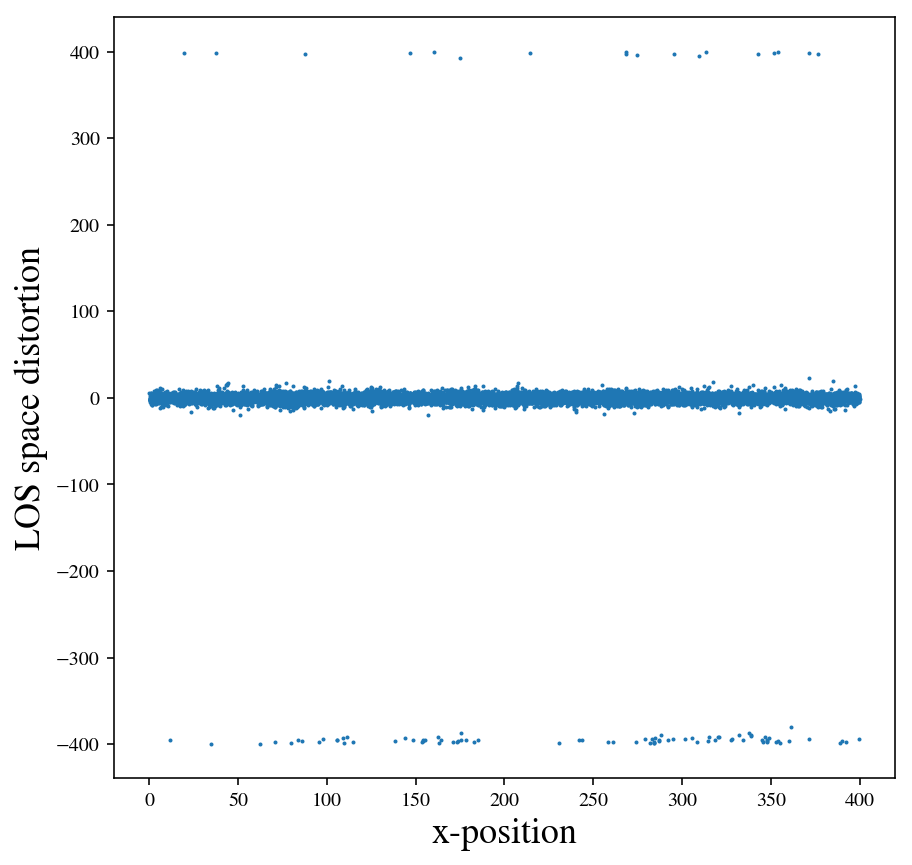

In [5]:
# look at redshift space distortions
fig = plt.figure(figsize = [7,7])

ax1 = fig.add_subplot(111)
ax1.scatter(model_table['x'],model_table['z'] - model_table['z_dist'], s = 1)
ax1.set_xlabel('x-position', fontsize = 18)
ax1.set_ylabel('LOS space distortion', fontsize = 18)

So it looks like the z-space distortions aren't bad. (The odd points at $\pm400$ are from the box size of the um model, which is $400Mpc$)

* Some of the galaxy positions are now weird because of the periodic boundary conditions.

(array([311., 268., 241., 270., 287., 261., 255., 243., 205., 268., 264.,
        246., 221., 195., 203., 225., 220., 278., 246., 241., 247., 287.,
        233., 257., 238., 231., 270., 299., 306., 305., 276., 236., 240.,
        249., 283., 265., 274., 304., 294., 376., 409., 346., 261., 298.,
        313., 302., 221., 250., 270., 270.]),
 array([3.57112194e-02, 8.03437159e+00, 1.60330320e+01, 2.40316923e+01,
        3.20303527e+01, 4.00290131e+01, 4.80276735e+01, 5.60263338e+01,
        6.40249942e+01, 7.20236546e+01, 8.00223149e+01, 8.80209753e+01,
        9.60196357e+01, 1.04018296e+02, 1.12016956e+02, 1.20015617e+02,
        1.28014277e+02, 1.36012938e+02, 1.44011598e+02, 1.52010258e+02,
        1.60008919e+02, 1.68007579e+02, 1.76006239e+02, 1.84004900e+02,
        1.92003560e+02, 2.00002221e+02, 2.08000881e+02, 2.15999541e+02,
        2.23998202e+02, 2.31996862e+02, 2.39995522e+02, 2.47994183e+02,
        2.55992843e+02, 2.63991503e+02, 2.71990164e+02, 2.79988824e+02,
        2.

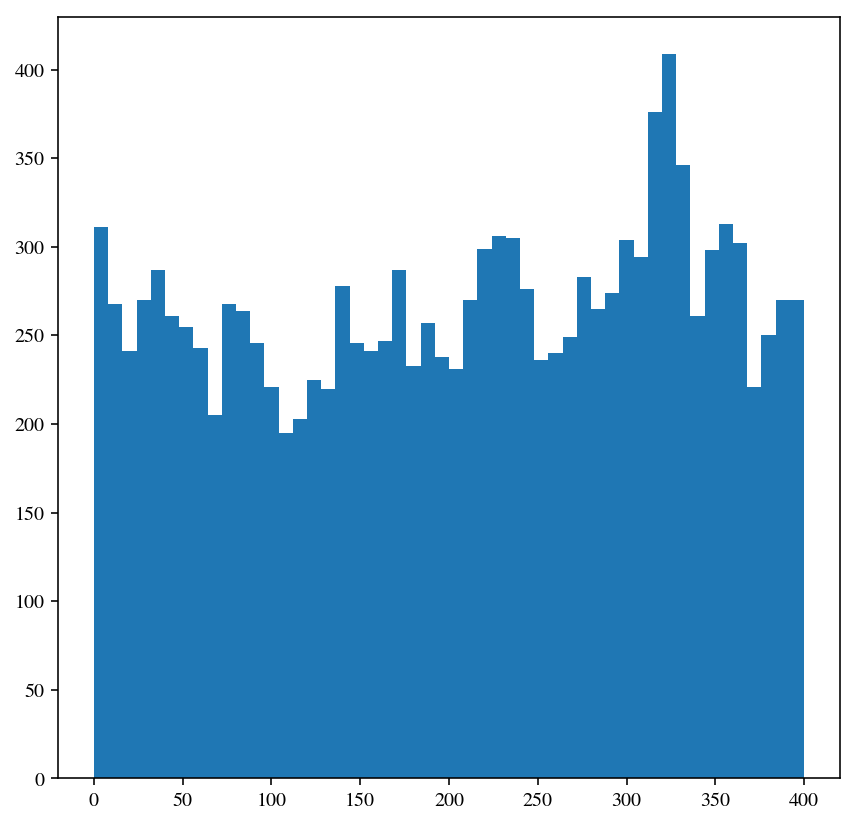

In [6]:
plt.figure(figsize = (7,7))
plt.hist(model_table['z_dist'], bins = 50)

* The next order of business is to turn the $\Delta z$ into physical $\Delta \ell$ (I think). From my conversation with Alexie at Shane, I want to convert our z-limits to comoving $h^{-1}$. For this, I can use `colossus.cosmology.comovingDistance`.

In [7]:
# first define the cosmology in colossus
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('huang18')
from colossus.halo import mass_so


In [8]:
# get rid of h in spatial coords
model_table['z_dist'] = model_table['z_dist']/h
model_table['x'] = model_table['x']/h
model_table['y'] = model_table['y']/h

Now I want to find the satellite fraction through the same process as the pdr region, except with a length cut.


### Apply same method to catalog

## True Satellite Fraction

* I just copy/pasted this from my other notebook. It needs some edits to keep it in similar form as other method

In [9]:
centrals_true = []
sats_true = []

for i in range(len(model_table)):
    if model_table['upid'][i] == -1:
        centrals_true.append(model_table['logms_tot_mod'][i])
    else:
        sats_true.append(model_table['logms_tot_mod'][i])
        
        
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


# from Song's satellite finding code
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(model_table['logms_tot_mod'], bins=mass_bins)
hist_cen, edges_cen = np.histogram(centrals_true, bins=mass_bins)
hist_sat, edges_sat = np.histogram(sats_true, bins=mass_bins)

mass_center_true = np.log10((10**edges_all[1:] + 10**edges_all[:-1]) / 2)

f_sat_true = (hist_sat / hist_all) * 100

In [10]:
# get virial radii
mvir = model_table['logmh_vir']
model_table['r_vir'] = (mass_so.M_to_R((10**mvir)*h , model_redshift, '200m')/h)*1e-3 #Mpc

# Make an index column
model_table['index'] = np.zeros(len(model_table['logms_tot_mod']))
for i in range(len(model_table['index'])):
     model_table['index'][i] = i

$\Rightarrow$ When I am applying this method, there are two key differences from the PDR
* $\Delta z$ cut is now a $\Delta \ell$ cut
* Distance between galaxies is calculated using x-y coordinates instead of RA and Dec

From what Marie sent me of the meeting on 6/21, I should be using these $\ell$ cuts:
* $\ell = 10Mpch^{-1}$
* $\ell = 15Mpch^{-1}$ $\Rightarrow$ velocity dispersion
* $\ell = 20Mpch^{-1}$
* $\ell = 50Mpch^{-1}$
* $\ell = 100Mpc^{-1}$ $\Rightarrow$ HSC $\sigma$

In [11]:
import satellite_finder as sf

#### Run using different  $\ell$ cuts

#### First, $\ell = 10$

In [12]:
# using l=10
mass_center_10mpc, f_sat_10mpc, err_10mpc = sf.run_model_satellite(model_table, 10/h, mass_bins)

#### Now use Chris' $\Delta \ell \sim 15Mpch^{-1}$

In [13]:
mass_center_15mpc, f_sat_15mpc, err_15mpc = sf.run_model_satellite(model_table, 15/h, mass_bins)

#### $\ell = 20$

In [14]:
mass_center_20mpc, f_sat_20mpc, err_20mpc = sf.run_model_satellite(model_table, 20/h, mass_bins)

#### $\ell = 50$

In [15]:
mass_center_50mpc, f_sat_50mpc, err_50mpc = sf.run_model_satellite(model_table, 50/h, mass_bins)

#### $\ell = 75$

In [16]:
mass_center_75mpc, f_sat_75mpc, err_75mpc = sf.run_model_satellite(model_table, 75/h, mass_bins)

#### $\ell = 100$

In [17]:
mass_center_100mpc, f_sat_100mpc, err_100mpc = sf.run_model_satellite(model_table, 100/h, mass_bins)

--------------- Error Bars --------------
* Song said I should put some "naive" error bars for reference. I will just do counting error.
$$ \sigma = \sqrt{n_{sat}}/n_{cent} * 100 $$

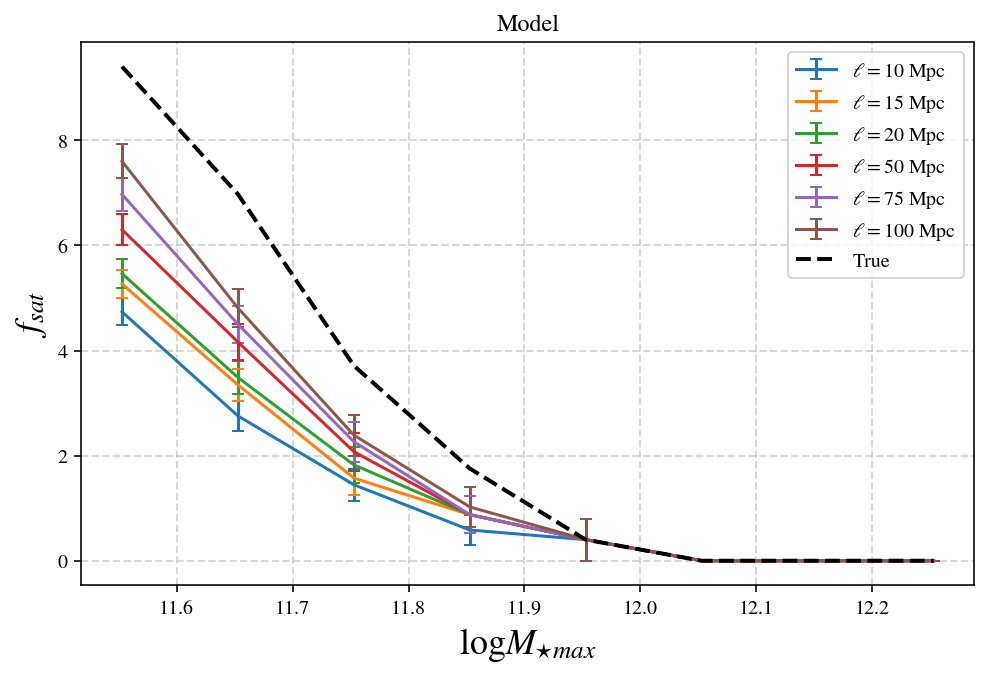

In [18]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, label = '$\ell = 10$ Mpc')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, label = '$\ell = 15$ Mpc')
ax1.errorbar(mass_center_20mpc , f_sat_20mpc, yerr = err_20mpc, capsize = 3, label = '$\ell = 20$ Mpc')
ax1.errorbar(mass_center_50mpc , f_sat_50mpc, yerr = err_50mpc, capsize = 3, label = '$\ell = 50$ Mpc')
ax1.errorbar(mass_center_75mpc , f_sat_75mpc, yerr = err_75mpc, capsize = 3, label = '$\ell = 75$ Mpc')
ax1.errorbar(mass_center_100mpc , f_sat_100mpc, yerr = err_100mpc, capsize = 3, label = '$\ell = 100$ Mpc')
ax1.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')


ax1.set_xlabel(r'$\log M_{\star max}$', fontsize = 18)
ax1.set_ylabel(r'$f_{sat}$', fontsize = 18)
ax1.set_title('Model')
ax1.legend()

#### Now we want to mock up photo-z errors.



1) Using `numpy.random.rand()`, I will draw random numbers based on the amount of galaxies with only photo-z

2) I will multiply the array of random numbers by the size of the galaxy bins, then convert those numbers to integers.

3) The integers will correspond to the indices of the rows of the table. These will be given the extra distortion, which I will work on next.

In [70]:
# find photo z fractions
pdr_no_specz = np.isnan(pdr_cut['z_spec'])

pdr_photoz = Table(names = pdr_cut.colnames) # table for only photo-z

for i in range(len(pdr_cut)):
    if pdr_no_specz[i] == True:
        pdr_photoz.add_row(pdr_cut[i])

hist_pdr, edges_pdr = np.histogram(pdr_cut['logm_max'], bins = mass_bins)
hist_phot_z, edges_phot_z = np.histogram(pdr_photoz['logm_max'], bins = mass_bins)

photoz_frac = hist_phot_z/hist_pdr
hist_pdr

array([1236,  667,  309,  129,   44,   14,    5,    1])

In [71]:
# Find how many random numbers to draw

random_sample0 = np.random.rand(hist_phot_z[0])
random_index0 = random_sample0 * hist_pdr[0]

random_sample1 = np.random.rand(hist_phot_z[1])
random_index1 = hist_pdr[0]+(random_sample1 * hist_pdr[1])

random_sample2 = np.random.rand(hist_phot_z[2])
random_index2 =hist_pdr[0]+hist_pdr[1]+ (random_sample2 * hist_pdr[2])

random_sample3 = np.random.rand(hist_phot_z[3])
random_index3 = hist_pdr[0]+hist_pdr[1]+hist_pdr[2]+(random_sample3 * hist_pdr[3])

random_sample4 = np.random.rand(hist_phot_z[4])
random_index4 = hist_pdr[0]+hist_pdr[1]+hist_pdr[2]+hist_pdr[3]+(random_sample4 * hist_pdr[4])

random_index = np.concatenate((random_index0, random_index1, random_index2, random_index3, random_index4), axis = 0)

# Turn array of indices into integers
for i in range(len(random_index)):
    random_index[i] = np.int(random_index[i])
    

random_index_integer = random_index.astype(int) # this is the final array of numbers to use
random_index_integer

array([ 311, 1211,  653,  900,  622,  902,  664, 1186,  531,  148, 1048,
        844, 1171,  730,  265,  375, 1088,  106, 1095,   24, 1137,  224,
       1187,  994,    7, 1171,  624,  682,  340,  121,  743,  420,  250,
       1185,  979,  941,  746,  961, 1161,  854,  271,  600,  629, 1183,
        303,  143, 1023,  848,   89, 1132,  505,  397, 1177, 1049,  363,
        453,   39,  916,  224,  607,  982,  946,  600,  894, 1045,  504,
       1188,  796,   33, 1169,  289,  842,  337,  913,  762,   55, 1085,
        312,  522,  312,  406,  983,  127, 1233,  298,  928,  680,  488,
        928, 1066,  489,  886,  722,  778,  838, 1127,  787,  950,  212,
        224,   90,  293,   30,   32,  368,  506,  452,  918,  306,  515,
        844, 1225,  733,  608, 1041,  905,  112,  570,  136,  766,  526,
        961,  733,  793,  480,  289,  859,  854, 1185,  943,   11,  288,
        398, 1348, 1896, 1842, 1737, 1282, 1757, 1337, 1530, 1414, 1654,
       1323, 1365, 1494, 1790, 1333, 1746, 1880, 18

This next part (actually creating and applying the kick) is where I'm a bit more unclear. I'm going to do what I *think* I'm supposed to do and see where that gets me. I will lay that out in the following markdown cell.

So from what Marie sent, I'm looking at a scatter of the form
$$ \sigma = \frac{\Delta z}{1 + z} \sim 0.03$$
If I'm supposed to find the $\Delta z$ and the corresponding comoving distance, then I would rearrange the function as $ \Delta z \sim 0.03(1 + z) $. In this case, $ z = z_{UM} = .37 $. Plugging in yields $\Delta z \sim 0.04$. From this, I can use `cosmo.comovingDistance()` to find the $\ell$. Once I have that, I will use `np.random.normal(0.0, cosmo.comovingDistance(.37, .37+.04))` for the kick.

In [72]:
delta_z = 0.04 # from above
l_comoving = cosmo.comovingDistance(0.37, 0.37 +delta_z)
print(l_comoving)

# here are the random distortions
l_kick = np.random.normal(0.0, l_comoving, size = len(random_index))

97.72030057321244


In [73]:
# ---------- Now add the distortions to the model data ----------

# Copy the original table so I can mess with the z-column
model_table_with_kick = copy.deepcopy(model_table)


# Add errors to the random rows
for i in range(len(random_index_integer)):
    model_table_with_kick['z_dist'][random_index_integer[i]] = \
    model_table_with_kick['z_dist'][random_index_integer[i]] + l_kick[i]

In [74]:
# ---------- Now run sat finding code ---------


# ---------- l = 10 ---------------------------------------
(mass_center_10mpc_kick, 
 f_sat_10mpc_kick, 
 err_10mpc_kick )= sf.run_model_satellite(model_table_with_kick, 10, mass_bins)

In [75]:
# ---------- l = 15 ---------------------------------------

(mass_center_15mpc_kick, 
 f_sat_15mpc_kick, 
 err_15mpc_kick )= sf.run_model_satellite(model_table_with_kick, 15, mass_bins)

KeyboardInterrupt: 

In [ ]:
# ---------- l = 20 ---------------------------------------

(mass_center_20mpc_kick, 
 f_sat_20mpc_kick, 
 err_20mpc_kick )= sf.run_model_satellite(model_table_with_kick, 20, mass_bins)

In [ ]:
# ---------- l = 50 ---------------------------------------

(mass_center_50mpc_kick, 
 f_sat_50mpc_kick, 
 err_50mpc_kick )= sf.run_model_satellite(model_table_with_kick, 50, mass_bins)

In [ ]:
# ---------- l = 75 ---------------------------------------

(mass_center_75mpc_kick, 
 f_sat_75mpc_kick, 
 err_75mpc_kick )= sf.run_model_satellite(model_table_with_kick, 75, mass_bins)

In [ ]:
# ---------- l = 100 ---------------------------------------

(mass_center_100mpc_kick, 
 f_sat_100mpc_kick, 
 err_100mpc_kick )= sf.run_model_satellite(model_table_with_kick, 100, mass_bins)

In [ ]:
fig = plt.figure(figsize = [30,10])
ax1 = fig.add_subplot(121)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, label = '$\ell = 10$ Mpc')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, label = '$\ell = 15$ Mpc')
ax1.errorbar(mass_center_20mpc , f_sat_20mpc, yerr = err_20mpc, capsize = 3, label = '$\ell = 20$ Mpc')
ax1.errorbar(mass_center_50mpc , f_sat_50mpc, yerr = err_50mpc, capsize = 3, label = '$\ell = 50$ Mpc')
ax1.errorbar(mass_center_75mpc , f_sat_75mpc, yerr = err_75mpc, capsize = 3, label = '$\ell = 75$ Mpc')
ax1.errorbar(mass_center_100mpc , f_sat_100mpc, yerr = err_100mpc, capsize = 3, label = '$\ell = 100$ Mpc')
ax1.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.set_xlabel(r'$\log M_{\star tot} / M_{\odot}$', fontsize = 30)
ax1.set_ylabel(r'$f_{sat}$ $(\%)$', fontsize = 30)
ax1.set_title('UM Model', fontsize = 30)
ax1.legend(fontsize = 20)

ax2 = fig.add_subplot(122, sharey = ax1)
ax2.grid(linewidth=1, linestyle='--', alpha=0.5)

ax2.errorbar(mass_center_10mpc_kick , f_sat_10mpc_kick, yerr = err_10mpc_kick, capsize = 3, label = '$\ell = 10$ Mpc')
ax2.errorbar(mass_center_15mpc_kick , f_sat_15mpc_kick, yerr = err_15mpc_kick, capsize = 3, label = '$\ell = 15$ Mpc')
ax2.errorbar(mass_center_20mpc_kick , f_sat_20mpc_kick, yerr = err_20mpc_kick, capsize = 3, label = '$\ell = 20$ Mpc')
ax2.errorbar(mass_center_50mpc_kick , f_sat_50mpc_kick, yerr = err_50mpc_kick, capsize = 3, label = '$\ell = 50$ Mpc')
ax2.errorbar(mass_center_75mpc_kick , f_sat_75mpc_kick, yerr = err_75mpc_kick, capsize = 3, label = '$\ell = 75$ Mpc')
ax2.errorbar(mass_center_100mpc_kick , f_sat_100mpc_kick, yerr = err_100mpc_kick, capsize = 3, label = '$\ell = 100$ Mpc')
ax2.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')


for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax2.set_xlabel(r'$\log M_{\star tot} / M_{\odot}$', fontsize = 30)
ax2.set_ylabel(r'$f_{sat}$ $(\%)$', fontsize = 30)
ax2.set_title('UM Model + Mock Photo-z Error', fontsize = 30)
ax2.legend(fontsize = 20)

plt.savefig('f_sat_two_panel.eps', dpi = 1000)